# Entrance Challenge: When Will the Sakura Bloom?

# 0. Basics of the Sakura Bloom-cycle (5pts total)

In [1]:
#%matplotlib inline
names=['serial' ,'year' ,'month' ,'day' ,'local_pressure' ,'sea_pressure' ,
    'total_preci' ,'hr1_preci' ,'min10_preci' ,'avg_temp' ,'max_temp' ,'min_temp' ,
       'avg_humid' ,'min_humid' ,'sun_hours' ,'bloom']

In a year, sakura trees basically go through 4 phases: energy production, hibernation, growth, and of course flowering. These phases
roughly follow the seasons, but not exactly. <br>

   Production phase： Initial development of the buds（Summer-Fall） <br>
   Hibernation phase： Bud growth stops while the tree goes into hibernation（Late Fall-Winter） <br>
   Growth phase： Buds once again continue to grow when the tree comes out of its winter hibernation（Late Winter-Spring） <br>
   Flowering phase： The buds finally bloom in spring (as climate conditions allow), once they have been able to fully develop.（Spring） <br>
    
Each year, near the end of winter but before the trees finally bloom, the hibernation period ends. The sakura that rested through the winter once gain become metabolically active, and the buds continue to grow (though we may not immediately notice when this happens.) However, the cycle is not simply clockwork- for example, in places where the temperature is above 20℃ year-round, the trees are unable to hibernate sufficiently, and thus cannot blossom.
    
In this challenge, we have outlined the basic mechanism by which the sakura reach their eventual bloom-date. We consider building a bloom-date prediction model for the case of sakura in Tokyo, with the data split as follows: <br>
    
Test years： 1966, 1971, 1985, 1994, and 2008 <br>
Training years: 1961 to 2017 (Excluding the test years) <br>
    
You should fit the model to the data from the training years, then use the model to predict the bloom-date for each of the test years. The 3 models to be applied to the data are described below.
    


### Problem 0-1: (5pts)
Acquire data of sakura blooming date (桜の開花日) for Tokyo from 1961 to 2018 using the Japanese Meteorological Agency website (気象庁).

***
## 1. Prediction using the "600 Degree Rule" (15pts total)

For a rough approximaton of the bloom-date, we start with a simple "rule-based" prediction model, called the "600 Degree Rule". The rule consists of logging the maximum temperature of each day, starting  on February 1st, and sum these temperatures until the sum surpasses 600$^\circ$C. The day that this happens is the predicted bloom-date. This 600$^\circ$C threshold is used to easily predict bloom-date in various locations varies by location. However, for more precise predictions, it should be set differently for every location. In this challenge, we verify the accuracy of the "600 Degree Rule" in the case of Tokyo.

### Problem 1-1: (5pts)
From here-on, we refer to the bloom-date in a given year $j$ as $BD_{j}$. For each year in the training data, calculate the accumulated daily maximum temperature from February 1st to the actual bloom-date $BD_{j}$, and plot this accumulated value over the training period. Then, average this accumulated value as $T_{mean}$, and verify whether we should use 600$^\circ$C as a rule for Tokyo.

### Importing Libraries

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import MinMaxScaler, RobustScaler

### Getting Data Ready

In [3]:
data_df=pd.read_csv('sakura.csv')
test_years= [1966, 1971, 1985, 1994,2008]
years=data_df['year'].unique()
train_years=[]
for year in years:
    if year not in test_years:
        train_years.append(year)

def get_yearly_dfs(df,year):
    year_gp=data_df.groupby('year')
    year_dfs={}
    for year in years:
        df=year_gp.get_group(year)
        df=df.reset_index()
        year_dfs[year]=df
    return year_dfs

In [4]:
def get_day_counts(yearly_dfs):
    yr_dfs=yearly_dfs.copy()
    for year in years:
        df=yr_dfs[year]
        ind=df.index.values.copy()
        ind+=1
        df['days']=ind
        yr_dfs[year]=df
    return yr_dfs
def get_acc_temps(yearly_dfs):
    yr_dfs=yearly_dfs.copy()
    for year in years:
        df=yr_dfs[year]
        acc_temp=0
        df['acc_temp']=0
        for row in range(len(df)):
            df_row=df.loc[row].copy()
            if df_row['month']>=2 and df_row['month']<=5:
                acc_temp+=df_row['max temp']
                df_row['acc_temp']=acc_temp
                df.loc[row]=df_row
        yr_dfs[year]=df
    return yr_dfs

In [5]:
yearly_dfs=get_yearly_dfs(data_df,years)
yearly_dfs=get_day_counts(yearly_dfs)
yearly_dfs=get_acc_temps(yearly_dfs)

### Problem 1-2: (10pts)

Use the average accumulated value $T_{mean}$ calculated in 1-1 to predict $BD_{j}$ for each test year, and show the error from the actual $BD_{j}$. Compare to the prediction results when 600$^\circ$C is used a threshold value, and evaluate both models using the coefficient of determination ($R^2$ score).

### 

In [6]:
def get_true_label(year_dfs,yrs):
    true_lb=[]
    acc_df=[]
    for year in yrs:
        df=year_dfs[year].copy()
        ind= (df['bloom']==1)
        ind=np.argmax(np.array(ind))
        acc_df.append(df.loc[ind,'acc_temp'])
        true_lb.append(df.loc[ind,'days'])              
        
    acc_df =pd.DataFrame(acc_df,index=yrs,columns=['temp'])
    true_lb=pd.DataFrame(true_lb,index=yrs,columns=['true_days'])
    return acc_df,true_lb


acc_df,_=get_true_label(yearly_dfs,train_years)
print('Mean accumulated temperature\n',acc_df.mean(),'\n')
thr_temp=acc_df.mean()

Mean accumulated temperature
 temp    638.355769
dtype: float64 



In [7]:
def predict(yearly_dfs,yrs,thr_temp):
    
    pred_lb=[]
    for year in yrs:
        _df=yearly_dfs[year]
        for i in range(len(_df)):
            if (_df.loc[i,'acc_temp']>thr_temp):
                pred_lb.append(_df.loc[i,'days'])
                break
    pred_lb=pd.DataFrame(pred_lb,index=yrs,columns=['pred_days'])
    return pred_lb       
_,true_lb=get_true_label(yearly_dfs,test_years)     
pred_lb_mean=predict(yearly_dfs,test_years,float(thr_temp))
pred_lb_600=predict(yearly_dfs,test_years,float(600))


In [8]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
#lbs=pd.concat([true_lb,pred_lb],axis=1)
true_lb=np.array(true_lb)
pred_lb_mean=np.array(pred_lb_mean)
pred_lb_600=np.array(pred_lb_600)
err_mean=np.square(np.array(true_lb)-np.array(pred_lb_mean))
err_600=np.square(np.array(true_lb)-np.array(pred_lb_600))
r2_1=r2_score(true_lb,pred_lb_mean)
r2_2=r2_score(true_lb,pred_lb_600)
print('error_mean',np.mean(err_mean),'\nerror_600',np.mean(err_600))
print('r2_score\n',r2_1,'\n',r2_2)
#error_mean 2.923076923076923 
#error_600 3.269230769230769
#error_mean 2.2 
#error_600 2.4

error_mean 4.6 
error_600 8.8
r2_score
 0.8323615160349854 
 0.6793002915451896


***
## 2. Linear Regression Model: Transform to Standard Temperature (30pts total)

The year to year fluctuation of the bloom-date depends heavily upon the actual temperature fluctuation (not just the accumulated maximum). In order to get to a more physiologically realistic metric,  Sugihara et al. (1986) considered the actual effect of temperature on biochemical activity. They introduced a method of "standardizing" the temperatures measured, according to the fluctuation relative to a standard temperature.

In order to make such a standardization, we apply two major assumptions, outlined below.

#### 1) The Arrhenius equation: <br>

The first assumption, also known in thermodynamics as the "Arrhenius equation", deals with chemical reaction rates and can be written as follows:

$$
k = A \exp{ \Bigl(- \frac{E_{a}}{RT}} \Bigr)
$$ <br>

Basically, it says that each reaction has an activation energy, $E_{a}$ and a pre-exponential factor $A$. Knowing these values for the particular equation, we can find the rate constant $k$ if we know the temperature, $T$, and applying the universal gas constant, $R = 8.314 \rm [J/K・mol]$.

#### 2) Constant output at constant temperature: <br>

The second assumption, is simply that the output of a reaction is a simple product of the duration and the rate constant $k$, and that product is constant even at different temperatures.
    
$$
tk = t'k' = t''k'' = \cdots = \rm{const}
$$ <br>


Making the assumptions above, we can determine a "standard reaction time", $t_{s}$ required for the bloom-date to occur. We can do so in the following way:

<br>
$$
t_{s} = \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
$$ <br>

We define $T_{i, j}$ as the daily average temperature, and use a standard temperature of $T_{s} = 17^\circ\rm{C}$. For a given year $j$, with the last day of the hibernation phase set as $D_ {j}$, we define the number of "transformed temperature days",  $DTS_{ J}$,  needed to reach from $D_ {j}$ to the bloom-date $BD_{j}$ with the following equation:


<br>
$$
DTS_{j} = \sum_{i=D_{j}}^{BD_{j}} t_{s} = \sum_{i=D_{j}}^{BD_{j}} \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
$$ <br>



From that equation, we can find the average $DTS$ for $x$ number of years ($DTS_{ mean}$) as follows: 

<br>
$$
\begin{align}
DTS_{\rm{mean}} &= \frac{1}{x} \sum_{j}^{x} DTS_{j} \\
&= \frac{1}{x} \sum_{j}^{x} \sum_{i=D_{j}}^{BD_{j}} \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
\end{align}
$$ <br> <br>

In this exercise, we assume that $DTS_{ mean}$ and $E_{ a}$ are constant values, and we use the data from the training years to fit these 2 constants. The exercise consists of 4 steps:
1. Calculate the last day of the hibernation phase $D_ {j}$ for every year $j$.
2. For every year $j$, calculate $DTS_{ j}$ as a function of $E_{ a}$, then calculate the average (over training years) $DTS_{ mean}$ also as a function of $E_{ a}$.
3. For every year $j$, and for every value of $E_{ a}$, accumulate $t_{s}$ from $D_ {j}$ and predict the bloom date $BD_{j}^{\rm{pred}}$ as the day the accumulated value surpasses $DTS_{ mean}$. Calculate the bloom date prediction error as a function of $E_{ a}$, and find the optimal $E_{ a}$ value that minimizes that error.
4. Use the previously calculated values of $D_ {j}$, $DTS_{ mean}$, and $E_{ a}$ to predict bloom-day on years from the test set.


### Problem 2-1: (5pts)
According to Hayashi et al. (2012), the day on which the sakura will awaken from their hibernation phase, $D_{j}$, for a given location, can be approximated by the following equation:
<br> <br>
$$
D_{j} = 136.75 - 7.689 \phi + 0.133 \phi^{2} -1.307\ln L + 0.144T_{F} + 0.285T_{F}^2
$$ <br>

where $\phi$ is the latitude [°N], $L$ is the distance from the nearest coastline [km], and $T_{F}$ is that location's average temperature [°C] over the first 3 months of a given year. In the case of Tokyo, $\phi = 35°40'$ and $L=4\rm{km}$.

Find the $D_{j}$ value for every year $j$ from 1961 to 2017 (including the test years), and plot this value on a graph. 

(In Problem 1, we had assumed a $D_j$ of February 1st.)

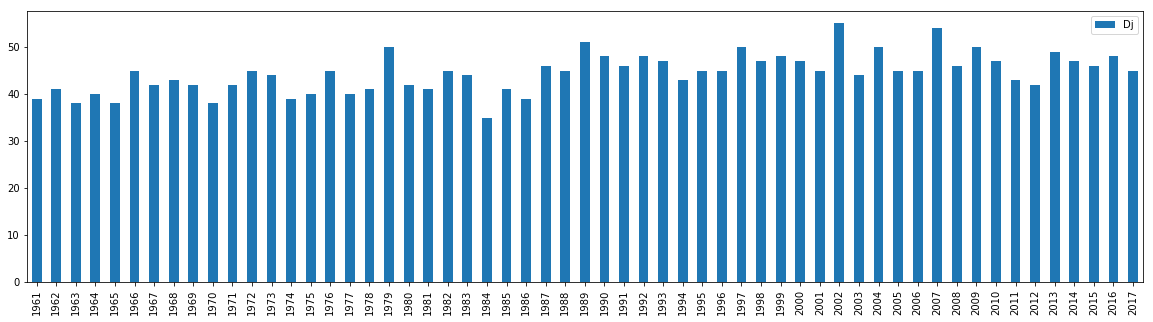

In [9]:
def get_Djs(yerly_dfs,years):
    Fi=35.67
    L=4
    Djs=[]
    for year in years:
        _df=yearly_dfs[year]
        Tf=_df[_df['month']<=3]['avg temp'].mean()
        𝐷j=136.75- 7.689*Fi+ 0.133*(Fi**2)- 1.307*np.log(L)+ 0.144*Tf+ 0.285*(Tf**2)
        Djs.append(int(Dj))
        
    Dj_df=pd.DataFrame(Djs,index=years,columns=['Dj'])
    return Dj_df
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(20,5))
Dj_df=get_Djs(yearly_dfs,years)
Dj_df.plot.bar(ax=axes)
#Dj_df.plot(ax=axes)
plt.show()

### Problem 2-2: (10pts)
Calcluate $DTS_j$ for each year $j$ in the training set for discrete values of $E_{a}$, varying from 5 to 40kcal ($E_{a} = 5, 6, 7, \cdots, 40 \,\rm{kcal}$), and plot this $DTS_j$ against $E_{a}$. Also calculate the average of $DTS_{j}$ over the training period, and indicate it on the plot as $DTS_{mean}$. Pay attention to the units of **every parameter** ($T_{i,j}$, $E_{a}$, ...) in the equation for $t_{s}$. 


In [10]:
def get_ts(Ea,Tj):
        R=8.314
        Ts=17
        A=Ea*(Tj-Ts)*4184
        B=R*(Tj+273)*(Ts+273)
        C=A/B
        return np.exp(C)

_,Bdj_df=get_true_label(yearly_dfs,years)

def get_dts(yearly_dfs,Ea,yrs):
    DTS_df=[]
    for year in yrs:
        _df=yearly_dfs[year]
        
        Dj=Dj_df.loc[year,'Dj']
        Bdj=Bdj_df.loc[year,'true_days']
        
        indx=_df['days']>=int(Dj) 
        indx&=_df['days']<=int(Bdj)
        Tjs=_df[indx]['avg temp']
        
        DTS=0
        for Tj in Tjs:
            DTS+=get_ts(Ea,Tj)
        DTS_df.append(DTS)
    DTS_df=pd.DataFrame(DTS_df,index=yrs,columns=['Ea_'+str(Ea)])
    return DTS_df

DTS_df=get_dts(yearly_dfs,5,train_years)
#Eas=list([0.001,0.002,0.003])
Eas=list(range(6,41))
for Ea in Eas:
    DTS_df=pd.concat([DTS_df,get_dts(yearly_dfs,Ea,train_years)],axis=1)

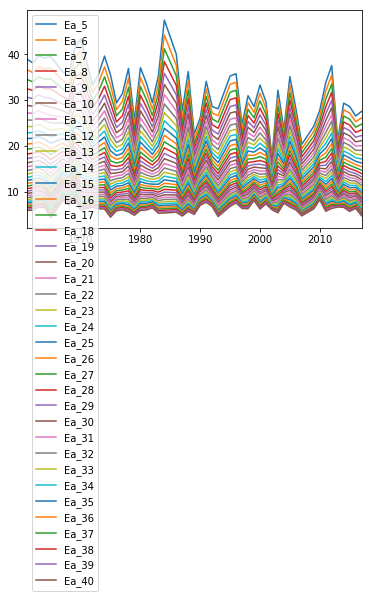

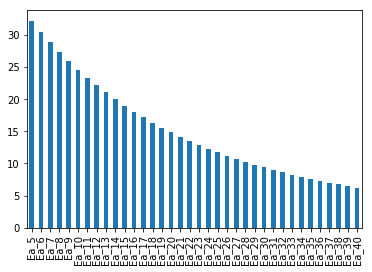

Ea_5     32.207353
Ea_6     30.487368
Ea_7     28.871963
Ea_8     27.354288
Ea_9     25.927966
Ea_10    24.587061
Ea_11    23.326045
Ea_12    22.139768
Ea_13    21.023433
Ea_14    19.972567
Ea_15    18.983002
Ea_16    18.050851
Ea_17    17.172491
Ea_18    16.344539
Ea_19    15.563839
Ea_20    14.827447
Ea_21    14.132613
Ea_22    13.476768
Ea_23    12.857516
Ea_24    12.272614
Ea_25    11.719968
Ea_26    11.197622
Ea_27    10.703743
Ea_28    10.236621
Ea_29     9.794654
Ea_30     9.376342
Ea_31     8.980284
Ea_32     8.605165
Ea_33     8.249756
Ea_34     7.912905
Ea_35     7.593532
Ea_36     7.290625
Ea_37     7.003235
Ea_38     6.730474
Ea_39     6.471507
Ea_40     6.225551
dtype: float64

In [11]:
DTS_df.plot()
plt.show()
DTS_df.mean().plot.bar()
plt.show()
DTS_df.mean()

In [12]:
def predict_ts(yearly_dfs,Ea,yrs,DTS_mean):
    pred_df=[]
    for year in yrs: 
        _df=yearly_dfs[year]
        
        Dj=Dj_df.loc[year,'Dj']
        indx=_df['days']>=int(Dj) 
        Tjs=_df[indx]['avg temp']
    
        DTS=0
        ind=Dj-1
        for Tj in Tjs:
            DTS+=get_ts(Ea,Tj)
            if DTS>=DTS_mean['Ea_'+str(Ea)] or ind>=(len(_df)-1):
                pred_Bdj=_df.loc[ind,'days']
                break
            ind+=1
            
                
        pred_df.append(pred_Bdj)
    pred_df=pd.DataFrame(pred_df,index=yrs,columns=['Ea_'+str(Ea)])
    return pred_df

In [13]:
pred_df=predict_ts(yearly_dfs,5,train_years,DTS_df.mean())
#Eas=list([0.001,0.002,0.003])
Eas=list(range(6,40))
for Ea in Eas:
    pred_df=pd.concat([pred_df,predict_ts(yearly_dfs,Ea,train_years,DTS_df.mean())],axis=1)


### Problem 2-3: (11pts)
Using the same $E_{a}$ values and calculated $DTS_{mean}$ from 2-2, predict the bloom date $BD_{j}$ for each of the training years. Find the mean squared error relative to the actual $BD$ and plot it against $E_{a}$. Find the optimal $E_{a}^{*}$ that minimizes that error on the training data.

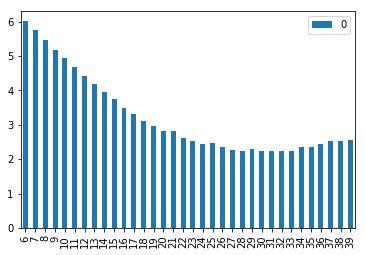

In [14]:
_,Bdj_df=get_true_label(yearly_dfs,train_years)
err_df=[]

for Ea in Eas: 
    err=0
    DTS=DTS_df.mean()['Ea_'+str(Ea)]
    for year in train_years:
        #DTS=DTS_df.loc[year,'Ea_'+str(Ea)]
        Dj=int(Dj_df.loc[year,'Dj'])
        pred_Bdj=pred_df.loc[year,'Ea_'+str(Ea)]
        true_Bdj=Bdj_df.loc[year,'true_days']
        #print(year,pred_Bdj)
        err+=np.abs(true_Bdj-pred_Bdj)
    err/=len(train_years)
    #print(Ea,err)
    err_df.append(err)
        
err_df=pd.DataFrame(err_df,index=Eas)
err_df.plot.bar()

### Problem 2-4: (4pts)

Using the $D_j$ dates from problem 2-1, the average $DTS_{mean}$ from 2-2, and the best-fit $E_{a}^{*}$ from 2-3, predict the bloom-dates $BD_j$ for the years in the test set. Determine the error between your predicted $BD_j$ values and the actual values, and evaluate this model using the coefficient of determination ($R^2$ score).

In [15]:
  
pred_df=predict_ts(yearly_dfs,30,test_years,DTS_df.mean())
_,Bdj_df=get_true_label(yearly_dfs,test_years)
err_df=[]
Ea=30
err=0

Bdj_df=np.array(Bdj_df)
pred_df=np.array(pred_df)
err=np.square(Bdj_df-pred_df)
err=np.mean(err)
r2_err=r2_score(Bdj_df,pred_df)
        
#err/=len(train_years)
print(Ea,err,r2_err)

30 0.8 0.9708454810495627


### Problem 2-5: (extra 10pts)
Discuss any improvements you could make to the model outlined above. If you have a suggestion in particular, describe it. How much do you think the accuracy would be improved?

1.According to the mentioned model and datasets, there is an assumption that the average temperature of a single day is sustained throughout the day. This is not the case in real life as the temperature can flactuate even from hour to hour. So if the fluctuations of the temperature could be added, the accuracy and could possibly be improved.



2.There are different species of cherry trees from the Prunus genus. Different species of trees might have different type if implecations to different changes of variables. We did not take that into account. If we can take those things into consideration, accuracy might be improved.

### Improvements : 
    1. Sun hours should be considered for getting dts as day light hours changes from day to day. Sun hours
    improved a the r2 score in Neural network prediction.
    2. Precipitaion can be complexly effect DTS , as during rain or cloud day ligh and temperature decreases, but     rain water may help to occur reaction, Below NN performance was imporved significantly by taking precipiation     in account.

***
## 3. Predicting Bloom-date via Neural Network (30pts total)

### Problem 3-1: (20pts)

Build a neural network and train it on the data from the training years. Use this model to predict the bloom-dates for each year in the test set. Evaluate the error between predicted dates and actual dates using the coefficient of determination (R2 score). Only use the weather data given in `tokyo.csv` and the sakura data acquired in problem 0-1.</br>
You may use whichever framework or strategy that you like to construct the network. 

### Data Preprocessing
1. Converting features of a whole year(365/366 samples) to a single vector for adding feature vector.
2. Feature Selection
3. Highly Corelated feaure specially anayzing and processing.
3. Finally building the train , validation and test data for further analysis.

### Converting each years data to a feature vector
Here some matters should be considered-

    1. Days after bloom can be ignored.
    2. Days days before Dj- Lastt day of hibernation is less significant
    3. Feature with high correlation i.e max temp can be specially considered for processing.
Considering this two issues several methods tried-

    1. Mean of first 90 days
    2. Mean of 30-90 th days
    3. mean of Dj-Dj+45 days
    4. Mean Dj-Dj+60 days
    5. Mean of Dj-Dj+75
   ![title](Report/Opt_dj.png)

Function : get_vectors
    
    Converts each years data to a single vector from a Dictionary of yearly dataframes where keys are the years.
    The mean is taken for Dj to Dj+60 days of a year. The reason is explained in the previous section.
    1. Input- Dictionary of dataframes, years, features.
    2. Output- features array,labels array,features dataframe

In [16]:
feats= [
'avg temp','max temp','min temp',
'total preci','hr1 preci','min10 preci',
'sun hours',
'local pressure','sea pressure',
'avg humid','min humid']

def get_vectors(dfs,_feats,yrs,scl=1):
    _,Bdj_df=get_true_label(yearly_dfs,yrs)
    _X=[]
    _Y=[]
    for year in yrs:
        _df=dfs[year]
        ind1=int(Dj-1)
        ind2=ind1+60
        df=_df.loc[ind1:ind2,:].copy()
        _X.append(df[_feats].mean())
        _Y.append(Bdj_df.loc[year])
    _X=np.array(_X)
    _Y=np.array(_Y)#-Dj_df.loc[year,'Dj'])

    scalar= RobustScaler()
    #scalar= MinMaxScaler()
    if scl==1:
        _X=scalar.fit(_X).transform(_X)
    n_df=pd.DataFrame(_X,columns=_feats)
    n_df['days']=_Y
    return _X,_Y,n_df

def plot_corr_sorted(df):
    corrmat = df.corr().abs()
    _corrmat=corrmat.sort_values( by=['days'],ascending=False)
    cm=(_corrmat['days'])
    cm=pd.DataFrame(cm)
    corr_cols=list(cm.index)
    sns.heatmap(df[corr_cols].corr().abs())
    return cm,corr_cols

### Feature Selection 
Following groups can be formed as they have same physical relation with bloom days. From the heatmap graph's high mutually correlations reconfirms this issue. Based on Correlation and preformance on test and validation data one feautre is selected from one group.

    1. 'avg temp','max temp','min temp', ------------------ max temp (performed best)
    2. 'total preci','hr1 preci','min10 preci',------------ hr1 preci (performed best)
    3. 'sun hours',---------------------------------------- sun hours (performed best)
    4.'local pressure','sea pressure',-------------------- local pressure (performed best)
    5. 'avg humid','min humid'----------------------------- avg humid (performed best)
    6. 'year' --------------------------------------------- year (performed best)

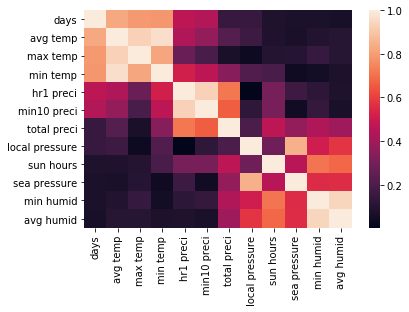

In [17]:
trainX,trainY,train_df=get_vectors(yearly_dfs,feats,train_years)
_,_=plot_corr_sorted(train_df)

### High correlation feauture : max temp, hr1 preci - Analysing
Temperarture mostly controlls the the bloom day as daily temperature helps the tree to gain the DTS for the reaction needed for bloom occur. So temperature is considered sepately.
    
    1. As the first quarter is a  season transition time differen months temperature can  effect differently effect the bloom date ,So taking mean of  like january , february , march in previous section can nullify their diversity. i.e as a part of winter february can be cooler than march which is part pf sprig.  
    
    2. Each months mean temperature is considered as separate feature and february and march have shown high correlation while janury and april was showing low correlation and adding them also degraded the performance of nn.
    
    3.As temperature of days before hibernation break cannot help to gain DTS conseuently not related to bloom that much so removing the days before Dj from february increased r2_score drastically which is shown in the bellow graph by shift of R2 score with mean of Feb_full to Fed_dj.
    
       Below is the Plot of R2 Score after adding each additional features or steps ---
       Where a simple nn with one layer lr-0.1 and epoc -500 used for quick testing.
       1. 'march only' -- one feauture that is mean of max temp of march.
       2. 'feb_full'   -- mean of february month max temp is added with march.
       3. 'feb_dj'     --Instead of mean of all tha days of february the days after Dj is considered. (Please notice the change here)
       4. 'hr1 preci'   --R2 score after hr1 preci as feature.
       5.  'sun hours'  -- R2 score after sun hours adding as feature.
       6.  'outliers'   --R2 score after removing outliers.
       7.  'lr-0.01'    --R2 score after changing learning rate to 0.01 with 3000 epocs.
       8.  'epoc-2500'  --R2 score after taking 2500 epocs.
![Plot of R2 Score after each additional steps](Report/prep_steps.png)

In [18]:
def split_monthly_temp(dfs,yrs):
    for year in yrs[:-1]:
        Dj=Dj_df.loc[year,'Dj']-1
        _df=dfs[year].copy()
        mn_gp=_df.groupby('month')
        feb=mn_gp.get_group(2)
        mrch=mn_gp.get_group(3)
        _df['max_temp_2']=feb.loc[Dj:,'max temp'].mean()#feb['max temp'].mean()
        _df['max_temp_3']=mrch['max temp'].mean()
        dfs[year]=_df
    return dfs
yearly_dfs=split_monthly_temp(yearly_dfs,years)
        

### Train , Validation , Test spliting and Scaling the data:

In [19]:
tr_years=[]
val_years=[]
for year in train_years:
    if year%5==0:
        val_years.append(year)
    else :
        tr_years.append(year)
tr_years=tr_years[:-1]

corr_feats=['max_temp_3','max_temp_2','hr1 preci','sun hours']#'local pressure','avg humid','year']
trainX,trainY,train_df=get_vectors(yearly_dfs,corr_feats,tr_years)
testX,testY,test_df=get_vectors(yearly_dfs,corr_feats,test_years)
valX,valY,val_df=get_vectors(yearly_dfs,corr_feats,val_years)
print('Train shapes     :',trainX.shape,trainY.shape)
print('Validation shape :',valX.shape,valY.shape)
print('Test shape       :',testX.shape,testY.shape)

Train shapes     : (41, 4) (41, 1)
Validation shape : (10, 4) (10, 1)
Test shape       : (5, 4) (5, 1)


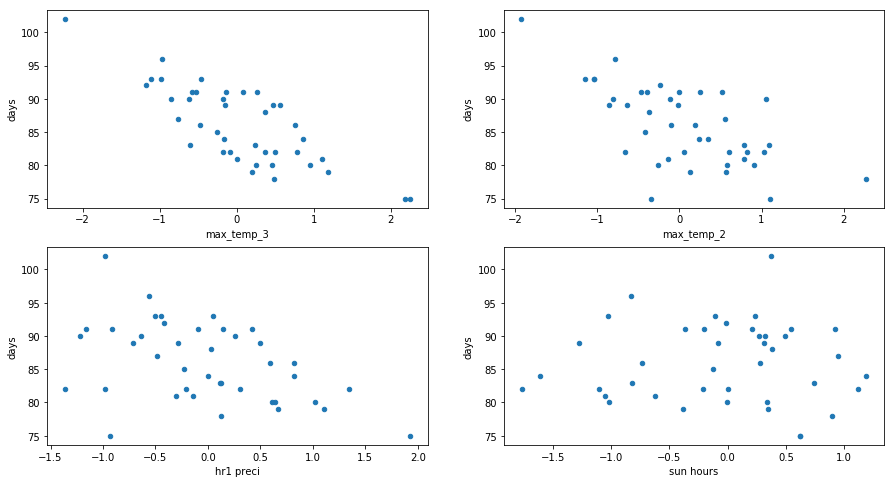

In [20]:
n=int(len(corr_feats)/2)
fig, axes = plt.subplots(nrows=2, ncols=n,figsize=(15,8))
for i in range(0,n):
    train_df.plot.scatter(x=corr_feats[i],y='days',ax=axes[0,i])#;axes[0,i].set_title(feats[i]);
    
for i in range(0,n):
    train_df.plot.scatter(x=corr_feats[i+n],y='days',ax=axes[1,i])#;axes[1,i].set_title(feats[i+3]);
plt.show()

### Handling Outliers :

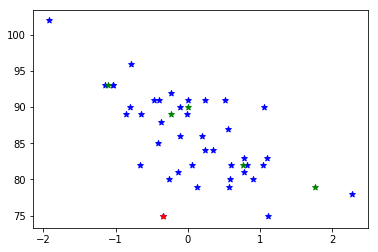

In [21]:
feat='max_temp_2'
outliers=(train_df[feat]<-0.0) & (train_df['days']<78)
plt.scatter(train_df.loc[:,feat],train_df.loc[:,'days'],marker='*',color='b')
plt.scatter(test_df.loc[:,feat],test_df.loc[:,'days'],marker='*',color='g')
plt.scatter(train_df.loc[outliers,feat],train_df.loc[outliers,'days'],marker='*',color='r')
plt.show()


In [22]:
ot_ind=np.array(np.where(outliers))
trainX=np.delete(trainX,ot_ind,axis=0)
trainY=np.delete(trainY,ot_ind,axis=0)
ot_ind

array([[38]])

### Hiperparameter tuning
#### Layers : 1 Layer
    1. 1 Layer was performing good
    2. 2 Layer was resulting little less (with 3,6,9 hidden nodes) r2 score and was taking more time to train.
    So simple model with one layer was preferred.
![Layers](Report/Layer_a.png)
![Layers](Report/Layer_c.png)
#### Learning Rate : 0.01
    1. lr-0.1 was learning very fast with a little less r2_score than 0.01
    2. lr-0.01 was perforing good with maximum r2 score
    3. lr-0.001 was very very slow needed 30000 epocs to train.
![Layers](Report/lr_a.png)
![Layers](Report/lr_c.png)
    1. Afer 2400 epocs validation error was increasing. 2500 epoc was optimum.
#### Epoc : 2500
![Layers](Report/1_layer_3000_epoc_0.01_lr_EP.png)
#### Batch size : 10
    1. Bach size 10 means 4 batches in  40 train data was prforming best. lower or higher batch size was giveng higher error.
#### Optimizer :
    1. SGD was giving more error.
    2. Adadelta was very long to train.
    1. Adam was taking about double epocs.
    2. RMSprop was learning fast and error was minimum.

In [23]:
layer=1
if layer==1:
    n_hidden_1 = 1
n_input = trainX.shape[1]
n_classes = 1#_train_y.shape[1]
if layer==2:
    n_hidden=9

class ANN():
    def __init__(self):
            init_zero=tf.zeros_initializer()
            init_glorot=tf.glorot_uniform_initializer()
            init_trunc_normal=tf.truncated_normal_initializer(stddev=1e-3)
            init_rand_norm=tf.random_normal_initializer(stddev=1e-3)
            with tf.variable_scope("weights", reuse=tf.AUTO_REUSE):
                    self.w1= tf.get_variable('w1',[n_input, n_hidden_1],dtype=tf.float64,initializer=init_glorot)
                    self.w2= tf.get_variable('w2',[n_hidden_1, n_classes],dtype=tf.float64,initializer=init_glorot)     
            with tf.variable_scope("biases", reuse=tf.AUTO_REUSE):
                    self.b1= tf.get_variable('b1',[n_hidden_1],dtype=tf.float64,initializer=init_zero)
                    self.b2= tf.get_variable('b2',[n_classes],dtype=tf.float64,initializer=init_zero)     
            self.weights=[self.w1,self.w2]
            self.biases = [self.b1,self.b2]
    def model_predict(self,x):
        out = tf.add(tf.matmul(x, self.weights[0]),self.biases[0])
        out = tf.nn.relu(out)
        if layer==2:
            out = tf.add(tf.matmul(out,self.weights[1]),self.biases[1])
            out = tf.nn.relu(out)
        return out
    
    def loss_func(self,y,out):
        _loss = tf.losses.mean_squared_error(labels=y, predictions=out)
        loss=tf.cast(_loss,tf.float64)
        return loss
    def reg_loss_func(self,loss,beta):
        beta=np.float64(beta)

        reg_w1=0.5*tf.reduce_sum(tf.square(self.weights[0]))
        reg_w2=0.5*tf.reduce_sum(tf.square(self.weights[1]))
        _reg=tf.add(reg_w1,reg_w2)

        reg=tf.cast(_reg,tf.float64)
        reg=tf.multiply(beta,reg)
        reg_loss=0.5*tf.add(loss,reg)
        
        return reg_loss
    def opt_func(self,lr,loss):
        if layer==1:
            trainable_vars=[self.w1,self.b1]
        if layer==2:
            trainable_vars=[self.w1,self.w2,self.b1,self.b2]
        #tf.GraphKeys.TRAINABLE_VARIABLE
        optimizer = tf.train.RMSPropOptimizer(lr)
        grads_and_vars=optimizer.compute_gradients(loss,trainable_vars)
        train_op=optimizer.apply_gradients(grads_and_vars)
        #train_op = optimizer.minimize(loss)
        return train_op
    
    def get_weights(self):
        return self.weights,self.biases
    
    def set_weights(self,wts,bias):
        self.weights[0]=tf.convert_to_tensor(wts[0])
        self.biases[0]=tf.convert_to_tensor(bias[0])
        self.weights[1]=tf.convert_to_tensor(wts[1])
        self.biases[1]=tf.convert_to_tensor(bias[1])
        

In [24]:
epoc=3000
#epoc=1000
lr=0.01
beta=5
no_of_batch=4 #(For Batch size of about 14-15)
xx=np.array_split(trainX,no_of_batch)
yy=np.array_split(trainY,no_of_batch)
xx_val=np.array_split(valX,no_of_batch)
yy_val=np.array_split(valY,no_of_batch)

In [25]:
import tensorflow as tf
tf.reset_default_graph()
x = tf.placeholder(tf.float64, shape=[None, trainX.shape[1]])
y=tf.placeholder(tf.float64, shape=[None, 1])

M=ANN()
out=M.model_predict(x)
loss=M.loss_func(y,out)

reg_loss=M.reg_loss_func(loss,beta)
train_op=M.opt_func(lr,loss)

In [26]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

#%matplotlib notebook
from IPython.display import clear_output


sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

t_loss=[]
v_loss=[]

#fig = plt.figure()
#ax = fig.add_subplot(111)
#plt.ion()
#fig.show()

for i in range(epoc+1):
    train_loss=0
    
    for j in range(0,len(xx)):
        inputs_train={x:xx[j],y:yy[j]}
        _= sess.run((train_op),feed_dict=inputs_train)
        loss_train = sess.run((loss),feed_dict=inputs_train)
        train_loss+=loss_train
    train_loss/=(j+1)
        
    val_loss=0
    for k in range(0,len(xx_val)):
        inputs_valid={x:xx_val[k],y:yy_val[k]}
        loss_valid = sess.run((loss),feed_dict=inputs_valid)
        val_loss+=loss_valid
        
    val_loss/=(k+1)
    t_loss.append(train_loss)
    v_loss.append(val_loss)
    
    disp_log=50
    if i>disp_log and i%disp_log==0:
        #clear_output()
        mt_loss=np.mean(np.array(t_loss[i-disp_log:i]))
        mv_loss=np.mean(np.array(v_loss[i-disp_log:i]))
        print('epoc:',i-disp_log,'-',i,'mean_train_loss:',mt_loss,'mean_valid_loss:',mv_loss)
    if i>30000:
        ax.clear()
        ax.plot(t_loss[-300:])
        ax.plot(v_loss[-300:])
        fig.canvas.draw()

epoc: 50 - 100 mean_train_loss: 6852.540561523438 mean_valid_loss: 7175.121196289063
epoc: 100 - 150 mean_train_loss: 6498.963059082032 mean_valid_loss: 6871.894616699219
epoc: 150 - 200 mean_train_loss: 6159.181867675781 mean_valid_loss: 6580.008615722656
epoc: 200 - 250 mean_train_loss: 5832.903625488281 mean_valid_loss: 6299.1329663085935
epoc: 250 - 300 mean_train_loss: 5519.883583984375 mean_valid_loss: 6029.045139160156
epoc: 300 - 350 mean_train_loss: 5219.870861816406 mean_valid_loss: 5769.508601074219
epoc: 350 - 400 mean_train_loss: 4932.608208007812 mean_valid_loss: 5520.270971679687
epoc: 400 - 450 mean_train_loss: 4657.830931396485 mean_valid_loss: 5281.061384277344
epoc: 450 - 500 mean_train_loss: 4395.380502929687 mean_valid_loss: 5053.321248779297
epoc: 500 - 550 mean_train_loss: 4145.773693847656 mean_valid_loss: 4839.738520507813
epoc: 550 - 600 mean_train_loss: 3906.6868029785155 mean_valid_loss: 4633.758331298828
epoc: 600 - 650 mean_train_loss: 3677.6247265625 mean

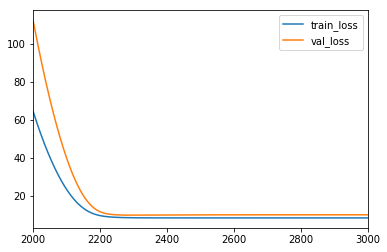

In [27]:
%matplotlib inline
loss_df=pd.DataFrame(np.array([t_loss,v_loss]).T,columns=['train_loss','val_loss'])
loss_df.loc[2000:].plot()
plt.show()

In [28]:
def predict_runtime(test_data):
    inputs_test={x:np.array(test_data)}
    res = sess.run((out),feed_dict=inputs_test)
    res = res.reshape(-1)
    return res
pred_trainY=predict_runtime(trainX)
pred_valY=predict_runtime(valX)
pred_testY=predict_runtime(testX)

In [29]:
tr_err=mean_squared_error(trainY,pred_trainY)
val_er=mean_squared_error(valY,pred_valY)
test_er=mean_squared_error(testY,pred_testY)
tr_r2=r2_score(trainY,pred_trainY)
val_r2=r2_score(valY,pred_valY)
test_r2=r2_score(testY,pred_testY)

print('Mean squared error',[tr_err,val_er,test_er])
print('R2 Score          ',[tr_r2,val_r2,test_r2])

Mean squared error [8.220798862647092, 10.036211419724548, 0.613301490806536]
R2 Score           [0.7449926680838436, 0.646612273953361, 0.9776493625799367]


In [30]:
import pickle
def save_weights(model):
    wts,bias=model.get_weights()
    wt,bs=sess.run((wts,bias))

    f=open("trained_params_","wb")
    pickle.dump([wt,bs],f)
    f.close()
def load_weights():
    f=open("trained_params_","rb")
    [wt,bs]=pickle.load(f)
    f.close()
    return wt,bs
def build_and_predict(test_data,wt,bs):
    tf.reset_default_graph()

    N=ANN()
    N.set_weights(wt,bs)
    tx = tf.placeholder(tf.float64, shape=[None, trainX.shape[1]])
    t_out=N.model_predict(tx)

    t_sess = tf.Session()
    init = tf.global_variables_initializer()
    t_sess.run(init)

    inputs_test={tx:np.array(test_data)}
    res = t_sess.run((t_out),feed_dict=inputs_test)
    res = res.reshape(-1)
    return res

In [31]:
#save_weights(model=M)
wt,bs=load_weights()
res=build_and_predict(testX,wt,bs)
r2_score(testY,res)

0.9776493376836249

### Problem 3-2: (10pts)
Compare the performance (via $R^2$ score) of the 3 implementations above: the 600 Degree Rule, the DTS method, and the neural network approach. For all methods, and each test year, plot the predicted date vs. the actual date. Discuss the accuracy and differences of these 3 models.

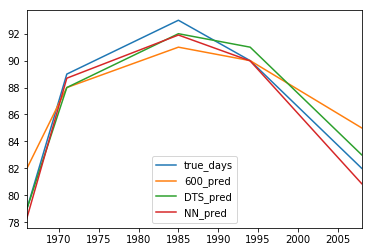

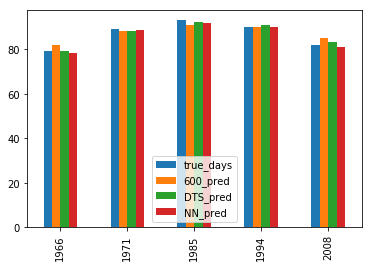

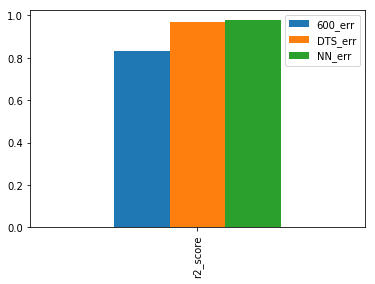

In [33]:
_,Days=get_true_label(yearly_dfs,test_years)
true_days=Days['true_days']
pred_600=np.array(predict(yearly_dfs,test_years,float(thr_temp)))
pred_DTS=np.array(predict_ts(yearly_dfs,30,test_years,DTS_df.mean()))
pred_NN=np.array(build_and_predict(testX,wt,bs))
#DTS_pred['true_days']
#plt.plot(pred_600['pred_days'])
#plt.plot(pred_DTS['Ea_30'])
#plt.plot(pred_NN)

_600_err=r2_score(true_days,pred_600)
DTS_err=r2_score(true_days,pred_DTS)
NN_err=r2_score(true_days,pred_NN)
errs=pd.DataFrame({'600_err':_600_err,'DTS_err':DTS_err,'NN_err':NN_err},index=['r2_score'])
Days['600_pred']=pred_600
Days['DTS_pred']=pred_DTS
Days['NN_pred']=pred_NN
Days.plot()
Days.plot.bar()
errs.plot.bar()

***
## 4. Trends of the Sakura blooming phenomenon (20pts total)

### Problem 4-1: (20pts)
Based on the data from the past 60 years, investigate and discuss trends in the sakura hibernation ($D_{j}$) and blooming ($BD_{j}$) phenomena in Tokyo.

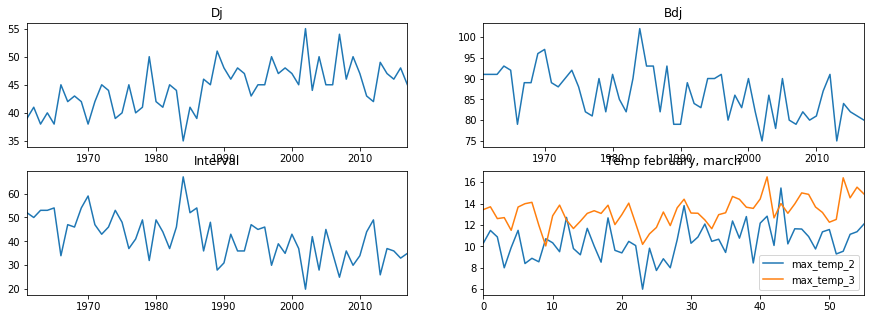

In [34]:
Dj_df=get_Djs(yearly_dfs,years)
_,Bdj=get_true_label(yearly_dfs,years)
comp_df=Dj_df
comp_df['Bdj']=Bdj['true_days']
comp_df['Diff']=(comp_df['Bdj']-comp_df['Dj'])
#comp_df['diff']=comp_df['Bdj']-comp_df['Dj']
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,5))
comp_df['Dj'].plot(ax=axes[0,0]);axes[0,0].set_title('Dj');
comp_df['Bdj'].plot(ax=axes[0,1]);axes[0,1].set_title('Bdj');
comp_df['Diff'].plot(ax=axes[1,0]);axes[1,0].set_title('Interval');
_,_,tdf=get_vectors(yearly_dfs,corr_feats,years[:-1],scl=0);axes[1,1].set_title('Temp february, march');
tdf[['max_temp_2','max_temp_3']].plot(ax=axes[1,1])
plt.show()



### Observations:

    During these 60 years :
    - Dj is increasing
    - Bdj is dereasing.
    - Dj-Bdj interval is decreasing.
    - Temperature is increasing.
    
    1. - 1961 Hibrnation used to end at 38-40 th day >> February 7-9 
       - 2016 Hibrnation used to end at 45-48 th day >> February 14-17
       >>about 1 week later.
    
    2. - 1961 First Bloom used to be at 91-93 th day >> April 1-3
       - 2016 First Bloom occurs at 80-82 th day  >> March 21-23
       >>about 10 days earlier.

    3. - 1961 Hibernation to bloom intterval was about 50-53 days
       - 1961 Hibernation to bloom intterval was about 33-36 days
       >>about 17 days less is required for reaching bloom from hibernation
       to occur.
    4. Reason is The temperature rise in february and march ,this is also 
    the reason for though Dj is 1 week delayed but bloom occurs 10 days 
    earlier in now compared to 1961.

    5. In the year 1984 there was a sudden drop in temperature so bloom day was delayed than  normal